In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import torch

## TO DO

1. Define SGD function
2. Define Newton's function
3. Define Quasi-Newton's method
4. Write simulation function (in-progress; BP)
5. Write simulation comparison code / Post Processing (in-progress; BP)

## FINISHED
1. Write data generating function
2. Write Normal Equation function (theoretical)

## Functions

In [2]:
#CREATE SIMULATION DATA
# creates feature matrix and corresponding observation.
# y - n x 1 matrix of normal distribution data of mu and sigma
# X - n x m matrix of parameters. First column is the intercept which is always 1
# Each parameter (column) is from the normal distribution of mu and sigma
# default is std norm: mu = 0, sd = 1
def create_sim_data_lr(n,m,mu = 0, sigma = 1):
    y = np.random.normal(mu,sigma,size = (n,1))    
    X = np.random.normal(mu,sigma,size = (n,m))
    X[:,0] = 1
    
    return ((X,y))


### Normal Equation (Theoretical)
# Closed Form Solution
# beta_hat = (X^T %*% X)^-1 %*% X %*% y
def normal_eq_lr(X,y):
    A = np.linalg.inv(np.matmul(np.transpose(X),X))
    B = np.matmul(np.transpose(X),y)
    return(np.matmul(A,B))


def simulate_lm(n_obs, m_betas, X=None, b=None):
    """Simulate a linear model as Xb = y.
    
    Parameters
    ----------
    n_obs : int
        Number of observatins (rows of X).
    m_beta : int
        Numbers of beta weights.
    X : 2d array, optional, default: None
        Features. Defaults to random normal.
    b : 1d array, optional default: None
        Beta weights. Default to random normal.
        
    Returns
    -------
    X : 2d tensor
        Features.
    b : 1d tensor
        Beta weights.
    y : 1d tensor
        Target.
    """
    
    # Initalize arrays
    if X is None:
        X = np.random.normal(size=(n_obs, m_betas))
        
    if b is None:
        b = np.random.normal(size=m_betas)

    # Solve y that corresponds to b and X
    y = np.dot(X, b).reshape(-1, 1)
    
    # Torch's linear layers require f32 tensors
    X = X.astype(np.float32)
    y = y.astype(np.float32)

    # Create tensors
    X = torch.from_numpy(X)
    b = torch.from_numpy(b)
    y = torch.from_numpy(y)
    
    return X, b, y


# MODELS / TRAINING
class LinearRegression(torch.nn.Module):
    """Muliple linear regression as a perceptron.
    
    Parameters
    ----------
    m_beta : int
        Numbers of beta weights.
    """
    def __init__(self, m_betas):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(m_betas, 1)
        
    def forward(self, x):
        return self.linear(x)
    
    
def train_model(X, y, method='SGD', lr=0.01, n_epochs=1000, opt_kwargs=None):
    """Train various models.
    
    Parameters
    ----------
    X : 2d tensor
        Features.
    y : 1d tensor
        Target.
    method : {'SGD', 'LBFGS', 'Newton'}
        Model to train.
    lr : float, optional, default: 0.01
        Learning rate (step size).
    n_epochs : int, optional, default: 1000
        Number of training iterations.
    opt_kwargs : dict, optional, default: None
        Optimizers kwargs to pass through to pytorch.
        
    Returns
    -------
    model : LinearRegression
        Trained model.
    loss_hist : 1d array
        Loss per step.
    elapsed : float
        Total time to train and run n_epochs.
    """
    
    # Initalize model and loss function
    model = LinearRegression(M)
    loss_func = torch.nn.MSELoss()
    loss_hist = np.zeros(n_epochs)
    
    # Select optimizer
    opt_kwargs = {} if opt_kwargs is None else opt_kwargs
    if method == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, **opt_kwargs)
    elif method == 'LBFGS':
        optimizer = torch.optim.LBFGS(model.parameters(), lr=lr, **opt_kwargs)
    
    # Time
    start = time.time()
    
    # Train
    for i in range(n_epochs):
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Get predicted y
        y_hat = model(X)

        # Compute loss
        loss = loss_func(y_hat, y)

        # Backpropagate and update weights
        loss.backward()
        optimizer.step()
        
        loss_hist[i] = loss
        
    # Time
    end = time.time()
    elapsed = end-start
    
    return model, loss_hist, elapsed

def evaluate_model(X, b, y):
    """Evaluate a trained model.
    
    Parameters
    ----------
    X : 2d tensor
        Features.
    b : 1d tensor
        Beta weights.
    y : 1d tensor
        Target.
        
    Returns
    -------
    y_hat : 1d tensor
        Predicted y-values.
    b_hat : 1d tensor
        Predicted beta weights.
    mse_y : float
        Mean-squared error of y and y_hat.
    mse_b : float
        Mean-squared error of b and b_hat.
    """
    
    # Get final predictions and weights
    y_hat = model(X)
    b_hat = model.linear.weight[0]
    
    # MSE
    mse_y = y_mse = float(((y - y_hat)**2).mean())
    mse_b = float(((b - b_hat)**2).sum())
    
    return y_hat, b_hat, mse_y, mse_b

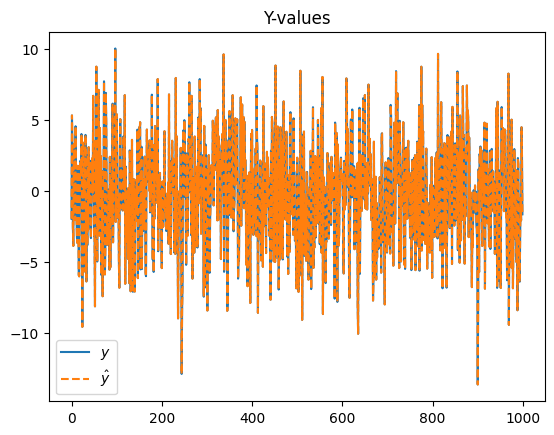

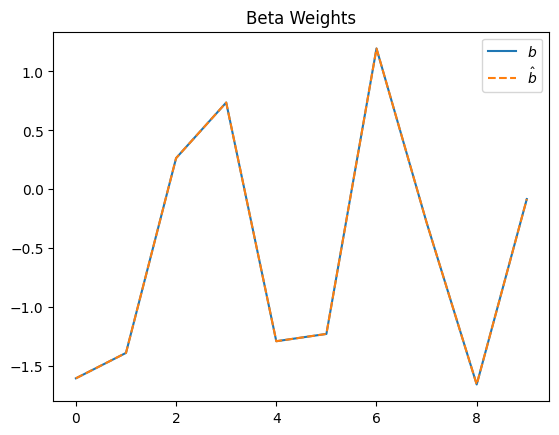

In [5]:
# Simulate
N = 1000      # training examples
M = 10        # beta weights

X, b, y = simulate_lm(N, M)

# Train
model, lost_hist, elapsed = train_model(X, y)

# Evaluate performance
y_hat, b_hat, mse_y, mse_b = evaluate_model(X, b, y)

plt.figure(0)
plt.title('Y-values')
plt.plot(y, label=r'$y$')
plt.plot(y_hat.detach().numpy(), ls='--', label=r'$\hat{y}$')
plt.legend()

plt.figure(1)
plt.title('Beta Weights')

plt.plot(b, label=r'$b$')
plt.plot(b_hat.detach().numpy(), ls='--', label=r'$\hat{b}$')
plt.legend();

## Simulations

The goal of these simulations is to create cases where we have n samples (could be low or high) and m features (1-1000). In the context of an optimization problem, compare the performance between SGD, Newton's method, and Quasi-Newton for each case.

Optimization problems to try: Regression, Classification (maybe if we don't have time, we can stick to regression only)

In [ ]:
nsim = 1000 # number of simulations
m = 1000 # number of features
n = 10000 # number of observations
np.random.seed(123) # set seed for reproducibility

res = {'normal-eq': dict(), 'sgd': dict(),'newton': dict(),'quasi-newton':dict()} # Store betas for each method here
res_time = {'normal-eq': dict(), 'sgd': dict(),'newton': dict(),'quasi-newton':dict()} # Store runtimes for each method here
for i in tqdm(range(nsim)):
    data = create_sim_data_lr(n,m) # for each iteration, generate new data
    
    ### Expected: beta_m parameters in a list
    
    # DO theoretical soln:
    # beta_hat = (X^T %*% X)^-1 %*% X %*% y
    # This solution might not be available...
    try:
        start = time.time()
        res['normal-eq'][i] = normal_eq_lr(data[0],data[1])[:,0].tolist()
        end = time.time()
        res_time['normal-eq'][i] = end-start # records the time elapsed to calculate
    except:
        res['normal-eq'][i] = 'Did not compute'
        res_time['normal-eq'][i] = 'NA'
    
    
    # DO SGD
    #res['sgd'][i] = 
    # DO NEWTON'S
    #res['newton'][i] = 
    # DO QUASI NEWTON'S
    #res['quasi-newton'][i] = 
    
    

In [ ]:
### VISUALIZATION FUNCTIONS TO COMPARE SIMULATION TIMES AS WELL AS BETAS FOR EACH METHOD
dfs = []
normal_eq_times = pd.DataFrame.from_dict(res_time['normal-eq'], orient='index')
normal_eq_betas = pd.DataFrame.from_dict(res['normal-eq']) # Each column is a simulation, Each row is a beta
#normal_eq_betas_vals = normal_eq_betas
normal_eq_beta_hats = normal_eq_betas.mean(axis=1)
normal_eq_beta_sds = normal_eq_betas.std(axis=1)

normal_eq_betas['beta_hat'] = normal_eq_beta_hats
normal_eq_betas['sd'] = normal_eq_beta_sds
#sgd_times = pd.DataFrame.from_dict(res_time['sgd'], orient='index')
#newton_times = pd.DataFrame.from_dict(res_time['newton'], orient='index')
#quasi_newton_times = pd.DataFrame.from_dict(res_time['quasi-newton'], orient='index')
#dfs.append(normal_eq_times,sgd_times,newton_times,quasi_newton_times)

#dfs = pd.concat(dfs,axis = 1) # combines all the times together into one matrix for easy computation
# get the mean time and sd for each method and plot in a violin plot? similar to what I showed in the midterm presentation


# X axis is betas
# Y axis is value

# overlay methods ontop of each other in different colors

## Models

In [ ]:
### SGD

### Newton's

### Quasi-Newton